In [49]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sci

image that has the correct ratio.
To create these figures, you must:
1. Ensure you can work with the event coordinates correctly. This includes
ensuring the shots are on the correct side of the rink (due to period changes, or
start on different sides during a game), as well as being able to map from
physical coordinates to pixel coordinates on the figure.
2. Compute aggregate statistics of shot locations across the entire league to
compute league average shot rate per hour. You can make a few simplifying
assumptions:
- You can assume all shots are even strength; this means you can simply
aggregate over all shots rather than having to figure out whether a shot
was an even strength shot or not (recall Q 4.2).
- You can assume each game lasts 60 minutes.
13

3. Group shots by team, and use the league average shot rate per hour computed
above to compute the excess shot rate per hour. You can choose to represent
this as either a raw difference in goals between the teams, or a percentage.
4. Make appropriate choices to bin your data when displaying it. You could also
consider using smoothing techniques to make your shot maps more readable. A
common strategy is to use kernel density estimation with a Gaussian kernel.


In [50]:
 #Let us look at our data 
df = pd.read_csv('all_shots_goals.csv')

In [51]:
print ( df.isna().any().sum())
df.head(10)

4


,game_id,season,game_time,period,period_time,event_type,team_id,team_name,coordinates_x,coordinates_y,shooter,goalie,shot_type,empty_net,strength,situation_code
0,2016020001,20162017,2016-10-12 23:00:00+00:00,1,01:11,shot,10,Maple Leafs,-77.0,5.0,Mitch Marner,Craig Anderson,wrist,False,Even Strength,1551
1,2016020001,20162017,2016-10-12 23:00:00+00:00,1,02:53,shot,9,Senators,86.0,13.0,Chris Kelly,Frederik Andersen,wrist,False,Even Strength,1551
2,2016020001,20162017,2016-10-12 23:00:00+00:00,1,04:01,shot,9,Senators,23.0,-38.0,Cody Ceci,Frederik Andersen,wrist,False,Even Strength,1551
3,2016020001,20162017,2016-10-12 23:00:00+00:00,1,04:46,shot,9,Senators,33.0,-15.0,Erik Karlsson,Frederik Andersen,slap,False,Even Strength,1551
4,2016020001,20162017,2016-10-12 23:00:00+00:00,1,06:46,shot,10,Maple Leafs,-34.0,28.0,Martin Marincin,Craig Anderson,wrist,False,Even Strength,1551
5,2016020001,20162017,2016-10-12 23:00:00+00:00,1,07:30,shot,10,Maple Leafs,-33.0,-17.0,Mitch Marner,Craig Anderson,wrist,False,Even Strength,1551
6,2016020001,20162017,2016-10-12 23:00:00+00:00,1,08:21,goal,10,Maple Leafs,-70.0,1.0,Auston Matthews,Craig Anderson,wrist,False,Even Strength,1551
7,2016020001,20162017,2016-10-12 23:00:00+00:00,1,08:29,shot,10,Maple Leafs,-45.0,-36.0,Matt Martin,Craig Anderson,wrist,False,Even Strength,1551
8,2016020001,20162017,2016-10-12 23:00:00+00:00,1,09:00,shot,9,Senators,33.0,-18.0,Erik Karlsson,Frederik Andersen,slap,False,Even Strength,1551
9,2016020001,20162017,2016-10-12 23:00:00+00:00,1,10:16,shot,9,Senators,34.0,20.0,Erik Karlsson,Frederik Andersen,wrist,False,Even Strength,1551


In [52]:
df.columns

Index(['game_id', 'season', 'game_time', 'period', 'period_time', 'event_type',
       'team_id', 'team_name', 'coordinates_x', 'coordinates_y', 'shooter',
       'goalie', 'shot_type', 'empty_net', 'strength', 'situation_code'],
      dtype='object')

In [53]:
# Let us just get the seasons, team name,  the x_cord and the y_cord, gameid, the rest of the data dont seem too relevant for this task 
df_sub = df[['game_id', 'season', 'team_name', 'coordinates_x', 'coordinates_y']]
df_sub = df_sub[df_sub['season'] == 20172018]
df_sub = df_sub.dropna()

In [54]:
df_league_stats =  df_sub[['game_id', 'season', 'team_name', 'coordinates_x', 'coordinates_y']]
df_league_stats = df_league_stats.dropna()

In [55]:
df_league_stats['coordinates_x'] = df_league_stats['coordinates_x'].apply(abs)
games_total = len ( df_league_stats['game_id'].unique())
#df_league_stats['coordinates_x'].max()
#df_league_stats['coordinates_x'].min()

In [56]:
'''
  ax.set_xlim(-100, 100)
  ax.set_ylim(-42.5, 42.5)
  '''
x_bins = np.linspace(0, 100, 10)
y_bins = np.linspace(-42.5, 42.5,10)

x_bins
#y_bins

array([  0.        ,  11.11111111,  22.22222222,  33.33333333,
        44.44444444,  55.55555556,  66.66666667,  77.77777778,
        88.88888889, 100.        ])

In [57]:
df_league_stats['coordinates_x_bins'] = pd.cut(df_league_stats['coordinates_x'], bins =  x_bins) # I think its better to bin first 
df_league_stats['coordinates_y_bins'] = pd.cut(df_league_stats['coordinates_y'], bins = y_bins )

In [58]:
df_league_stats

suspicious = df_league_stats[(df_league_stats["coordinates_x"] > 98) & (df_league_stats["coordinates_x"] <= 100)]
print("Number of suspicious shots:", len(suspicious))
suspicious.head()


Number of suspicious shots: 2


,game_id,season,team_name,coordinates_x,coordinates_y,coordinates_x_bins,coordinates_y_bins
96871,2017020256,20172018,Blackhawks,99.0,-4.0,"(88.889, 100.0]","(-4.722, 4.722]"
104384,2017020373,20172018,Blackhawks,99.0,-10.0,"(88.889, 100.0]","(-14.167, -4.722]"


In [59]:
df_aggregate_counts_league  = df_league_stats.groupby(['coordinates_x_bins', 'coordinates_y_bins'], observed=False ).size().reset_index(name="counts")

In [60]:
df_aggregate_counts_league[df_aggregate_counts_league['counts'] == df_aggregate_counts_league['counts'].max()]

,coordinates_x_bins,coordinates_y_bins,counts
67,"(77.778, 88.889]","(-4.722, 4.722]",6161


In [61]:
df_aggregate_counts_league['sr/h'] = df_aggregate_counts_league['counts'] /  ( 2 * len ( df_league_stats['game_id'].unique()) )

In [62]:
df_aggregate_counts_league[df_aggregate_counts_league['counts'] == df_aggregate_counts_league['counts'].max()]


,coordinates_x_bins,coordinates_y_bins,counts,sr/h
67,"(77.778, 88.889]","(-4.722, 4.722]",6161,2.273432


In [63]:
df_aggregate_counts_league

,coordinates_x_bins,coordinates_y_bins,counts,sr/h
0,"(0.0, 11.111]","(-42.5, -33.056]",167,0.061624
1,"(0.0, 11.111]","(-33.056, -23.611]",198,0.073063
2,"(0.0, 11.111]","(-23.611, -14.167]",112,0.041328
3,"(0.0, 11.111]","(-14.167, -4.722]",96,0.035424
4,"(0.0, 11.111]","(-4.722, 4.722]",191,0.070480
...,...,...,...,...
76,"(88.889, 100.0]","(-4.722, 4.722]",28,0.010332
77,"(88.889, 100.0]","(4.722, 14.167]",164,0.060517
78,"(88.889, 100.0]","(14.167, 23.611]",81,0.029889
79,"(88.889, 100.0]","(23.611, 33.056]",57,0.021033


In [64]:
df_aggregate_counts_league[df_aggregate_counts_league['counts'] == df_aggregate_counts_league['counts'].max()]


,coordinates_x_bins,coordinates_y_bins,counts,sr/h
67,"(77.778, 88.889]","(-4.722, 4.722]",6161,2.273432


In [65]:
TML_data  = df_sub[df_sub['team_name'] == 'Sharks']

In [66]:
TML_data

,game_id,season,team_name,coordinates_x,coordinates_y
80606,2017020004,20172018,Sharks,29.0,-40.0
80607,2017020004,20172018,Sharks,-28.0,24.0
80608,2017020004,20172018,Sharks,-31.0,-15.0
80613,2017020004,20172018,Sharks,-67.0,34.0
80614,2017020004,20172018,Sharks,-35.0,-18.0
...,...,...,...,...,...
166530,2017030246,20172018,Sharks,-48.0,38.0
166531,2017030246,20172018,Sharks,-64.0,-16.0
166532,2017030246,20172018,Sharks,-72.0,-14.0
166534,2017030246,20172018,Sharks,-49.0,-10.0


In [67]:
TML_data['coordinates_x'] = TML_data['coordinates_x'].apply(abs)



C:\Users\Goofy\AppData\Local\Temp\ipykernel_10628\2090272427.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TML_data['coordinates_x'] = TML_data['coordinates_x'].apply(abs)


In [68]:
print( len ( TML_data['game_id'].unique()) )
print(TML_data)

92
           game_id    season team_name  coordinates_x  coordinates_y
80606   2017020004  20172018    Sharks           29.0          -40.0
80607   2017020004  20172018    Sharks           28.0           24.0
80608   2017020004  20172018    Sharks           31.0          -15.0
80613   2017020004  20172018    Sharks           67.0           34.0
80614   2017020004  20172018    Sharks           35.0          -18.0
...            ...       ...       ...            ...            ...
166530  2017030246  20172018    Sharks           48.0           38.0
166531  2017030246  20172018    Sharks           64.0          -16.0
166532  2017030246  20172018    Sharks           72.0          -14.0
166534  2017030246  20172018    Sharks           49.0          -10.0
166536  2017030246  20172018    Sharks           69.0           30.0

[3079 rows x 5 columns]


In [69]:
TML_data['coordinates_x_bins'] = pd.cut(TML_data['coordinates_x'],bins = x_bins  )
TML_data['coordinates_y_bins'] = pd.cut(TML_data['coordinates_y'], bins = y_bins)

C:\Users\Goofy\AppData\Local\Temp\ipykernel_10628\2364255378.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TML_data['coordinates_x_bins'] = pd.cut(TML_data['coordinates_x'],bins = x_bins  )
C:\Users\Goofy\AppData\Local\Temp\ipykernel_10628\2364255378.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  TML_data['coordinates_y_bins'] = pd.cut(TML_data['coordinates_y'], bins = y_bins)


In [70]:
TML_data

,game_id,season,team_name,coordinates_x,coordinates_y,coordinates_x_bins,coordinates_y_bins
80606,2017020004,20172018,Sharks,29.0,-40.0,"(22.222, 33.333]","(-42.5, -33.056]"
80607,2017020004,20172018,Sharks,28.0,24.0,"(22.222, 33.333]","(23.611, 33.056]"
80608,2017020004,20172018,Sharks,31.0,-15.0,"(22.222, 33.333]","(-23.611, -14.167]"
80613,2017020004,20172018,Sharks,67.0,34.0,"(66.667, 77.778]","(33.056, 42.5]"
80614,2017020004,20172018,Sharks,35.0,-18.0,"(33.333, 44.444]","(-23.611, -14.167]"
...,...,...,...,...,...,...,...
166530,2017030246,20172018,Sharks,48.0,38.0,"(44.444, 55.556]","(33.056, 42.5]"
166531,2017030246,20172018,Sharks,64.0,-16.0,"(55.556, 66.667]","(-23.611, -14.167]"
166532,2017030246,20172018,Sharks,72.0,-14.0,"(66.667, 77.778]","(-14.167, -4.722]"
166534,2017030246,20172018,Sharks,49.0,-10.0,"(44.444, 55.556]","(-14.167, -4.722]"


In [71]:
df_aggregate_counts_TML  = TML_data.groupby(['coordinates_x_bins', 'coordinates_y_bins'], observed=False).size().reset_index(name="counts")

In [72]:
df_aggregate_counts_TML[df_aggregate_counts_TML['counts'] ==df_aggregate_counts_TML['counts'].max() ]

,coordinates_x_bins,coordinates_y_bins,counts
67,"(77.778, 88.889]","(-4.722, 4.722]",267


In [73]:
df_aggregate_counts_TML['sr/h'] = df_aggregate_counts_TML['counts'] /len ( TML_data['game_id'].unique())

In [74]:
df_aggregate_counts_TML[df_aggregate_counts_TML['sr/h'] ==df_aggregate_counts_TML['sr/h'].max() ]

,coordinates_x_bins,coordinates_y_bins,counts,sr/h
67,"(77.778, 88.889]","(-4.722, 4.722]",267,2.902174


In [75]:
#So now we have the league shot rate/hr and the team shot rate/hr 
print ( df_aggregate_counts_TML)
print (df_aggregate_counts_league)

   coordinates_x_bins  coordinates_y_bins  counts      sr/h
0       (0.0, 11.111]    (-42.5, -33.056]       0  0.000000
1       (0.0, 11.111]  (-33.056, -23.611]       7  0.076087
2       (0.0, 11.111]  (-23.611, -14.167]       0  0.000000
3       (0.0, 11.111]   (-14.167, -4.722]       6  0.065217
4       (0.0, 11.111]     (-4.722, 4.722]       5  0.054348
..                ...                 ...     ...       ...
76    (88.889, 100.0]     (-4.722, 4.722]       2  0.021739
77    (88.889, 100.0]     (4.722, 14.167]       7  0.076087
78    (88.889, 100.0]    (14.167, 23.611]       6  0.065217
79    (88.889, 100.0]    (23.611, 33.056]       1  0.010870
80    (88.889, 100.0]      (33.056, 42.5]       1  0.010870

[81 rows x 4 columns]
   coordinates_x_bins  coordinates_y_bins  counts      sr/h
0       (0.0, 11.111]    (-42.5, -33.056]     167  0.061624
1       (0.0, 11.111]  (-33.056, -23.611]     198  0.073063
2       (0.0, 11.111]  (-23.611, -14.167]     112  0.041328
3       (0.0, 11.

In [76]:
test = pd.merge(
    df_aggregate_counts_TML,
    df_aggregate_counts_league,
    on=["coordinates_x_bins", "coordinates_y_bins"],
    how="outer"
)

In [77]:
test

,coordinates_x_bins,coordinates_y_bins,counts_x,sr/h_x,counts_y,sr/h_y
0,"(0.0, 11.111]","(-42.5, -33.056]",0,0.000000,167,0.061624
1,"(0.0, 11.111]","(-33.056, -23.611]",7,0.076087,198,0.073063
2,"(0.0, 11.111]","(-23.611, -14.167]",0,0.000000,112,0.041328
3,"(0.0, 11.111]","(-14.167, -4.722]",6,0.065217,96,0.035424
4,"(0.0, 11.111]","(-4.722, 4.722]",5,0.054348,191,0.070480
...,...,...,...,...,...,...
76,"(88.889, 100.0]","(-4.722, 4.722]",2,0.021739,28,0.010332
77,"(88.889, 100.0]","(4.722, 14.167]",7,0.076087,164,0.060517
78,"(88.889, 100.0]","(14.167, 23.611]",6,0.065217,81,0.029889
79,"(88.889, 100.0]","(23.611, 33.056]",1,0.010870,57,0.021033


In [78]:
test["excess_shot"] =((test["sr/h_x"] - test["sr/h_y"])  )   

In [79]:
test

,coordinates_x_bins,coordinates_y_bins,counts_x,sr/h_x,counts_y,sr/h_y,excess_shot
0,"(0.0, 11.111]","(-42.5, -33.056]",0,0.000000,167,0.061624,-0.061624
1,"(0.0, 11.111]","(-33.056, -23.611]",7,0.076087,198,0.073063,0.003024
2,"(0.0, 11.111]","(-23.611, -14.167]",0,0.000000,112,0.041328,-0.041328
3,"(0.0, 11.111]","(-14.167, -4.722]",6,0.065217,96,0.035424,0.029793
4,"(0.0, 11.111]","(-4.722, 4.722]",5,0.054348,191,0.070480,-0.016132
...,...,...,...,...,...,...,...
76,"(88.889, 100.0]","(-4.722, 4.722]",2,0.021739,28,0.010332,0.011407
77,"(88.889, 100.0]","(4.722, 14.167]",7,0.076087,164,0.060517,0.015570
78,"(88.889, 100.0]","(14.167, 23.611]",6,0.065217,81,0.029889,0.035328
79,"(88.889, 100.0]","(23.611, 33.056]",1,0.010870,57,0.021033,-0.010164


In [80]:
final_test  = test[['coordinates_x_bins', 'coordinates_y_bins', 'excess_shot']]


In [81]:
final_df = final_test.pivot( index ='coordinates_x_bins', columns='coordinates_y_bins', values= 'excess_shot')

In [82]:
final_df

coordinates_y_bins,"(-42.5, -33.056]","(-33.056, -23.611]","(-23.611, -14.167]","(-14.167, -4.722]","(-4.722, 4.722]","(4.722, 14.167]","(14.167, 23.611]","(23.611, 33.056]","(33.056, 42.5]"
coordinates_x_bins,,,,,,,,,
"(0.0, 11.111]",-0.061624,0.003024,-0.041328,0.029793,-0.016132,-0.010934,-0.005030,-0.059811,-0.039515
"(11.111, 22.222]",-0.009827,-0.026496,-0.038208,0.012081,-0.009321,-0.026432,-0.024186,-0.048203,-0.034518
"(22.222, 33.333]",0.015001,0.174162,0.107934,0.059891,0.083948,0.025806,0.164864,0.202310,0.039122
"(33.333, 44.444]",-0.022301,-0.015979,0.194730,0.135432,-0.008014,-0.085216,0.092066,0.374258,0.163525
"(44.444, 55.556]",0.081534,-0.144882,0.007797,0.030964,-0.044080,-0.053377,-0.046791,0.040703,-0.097008
"(55.556, 66.667]",0.063421,-0.086243,0.041352,-0.057147,0.031293,-0.107805,-0.093310,-0.009819,0.018771
"(66.667, 77.778]",-0.013509,-0.118129,-0.018338,0.018627,0.400939,-0.197513,-0.112410,-0.140839,0.045572
"(77.778, 88.889]",0.026039,-0.038160,-0.164993,-0.082408,0.628742,0.056000,0.002070,0.006963,-0.002743
"(88.889, 100.0]",-0.003321,0.010099,0.025197,0.032512,0.011407,0.015570,0.035328,-0.010164,0.007549


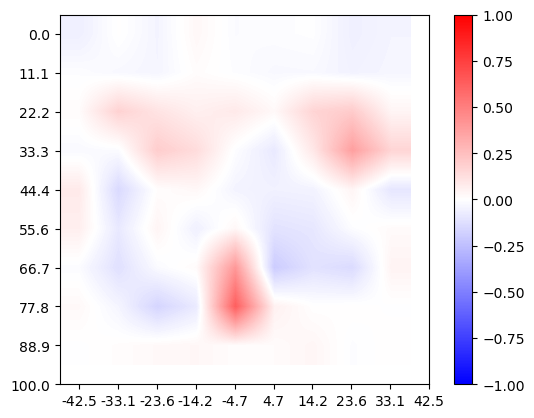

In [83]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

indexes = final_df.index 
y_cols = final_df.columns
df_finale = pd.DataFrame(final_df, index=indexes, columns=y_cols)
plt.imshow(df_finale, cmap="bwr", interpolation='bilinear', vmin=-1, vmax=1)
plt.xticks(ticks=np.arange(len(y_bins)), labels=np.round(y_bins, 1))
plt.yticks(ticks=np.arange(len(x_bins)), labels=np.round(x_bins, 1))
plt.colorbar() 
plt.show()


In [84]:
df_finale.head(10)

coordinates_y_bins,"(-42.5, -33.056]","(-33.056, -23.611]","(-23.611, -14.167]","(-14.167, -4.722]","(-4.722, 4.722]","(4.722, 14.167]","(14.167, 23.611]","(23.611, 33.056]","(33.056, 42.5]"
coordinates_x_bins,,,,,,,,,
"(0.0, 11.111]",-0.061624,0.003024,-0.041328,0.029793,-0.016132,-0.010934,-0.005030,-0.059811,-0.039515
"(11.111, 22.222]",-0.009827,-0.026496,-0.038208,0.012081,-0.009321,-0.026432,-0.024186,-0.048203,-0.034518
"(22.222, 33.333]",0.015001,0.174162,0.107934,0.059891,0.083948,0.025806,0.164864,0.202310,0.039122
"(33.333, 44.444]",-0.022301,-0.015979,0.194730,0.135432,-0.008014,-0.085216,0.092066,0.374258,0.163525
"(44.444, 55.556]",0.081534,-0.144882,0.007797,0.030964,-0.044080,-0.053377,-0.046791,0.040703,-0.097008
"(55.556, 66.667]",0.063421,-0.086243,0.041352,-0.057147,0.031293,-0.107805,-0.093310,-0.009819,0.018771
"(66.667, 77.778]",-0.013509,-0.118129,-0.018338,0.018627,0.400939,-0.197513,-0.112410,-0.140839,0.045572
"(77.778, 88.889]",0.026039,-0.038160,-0.164993,-0.082408,0.628742,0.056000,0.002070,0.006963,-0.002743
"(88.889, 100.0]",-0.003321,0.010099,0.025197,0.032512,0.011407,0.015570,0.035328,-0.010164,0.007549


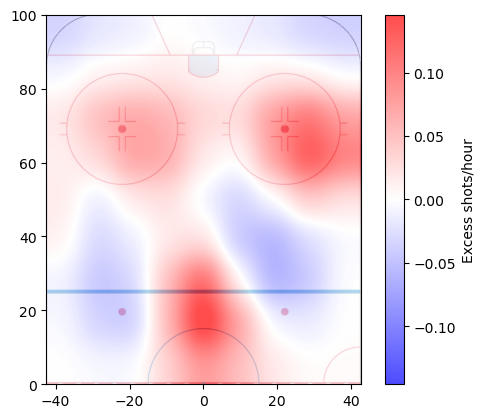

In [85]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

ring = "../../figures/nhl_rink.png"

rink_full = Image.open(ring).convert("RGBA")
W, H = rink_full.size
rink_half = rink_full.crop((W/2, 0, W, H))
rink_half_rot = rink_half.transpose(Image.ROTATE_90)


X_MIN, X_MAX = -42.5, 42.5
Y_MIN, Y_MAX = 0, 100
Z = gaussian_filter(final_df.values, sigma=0.8, mode="nearest")
z_min, z_max = np.percentile(Z, [2, 98])  # clip extremes
max_abs = max(abs(z_min), abs(z_max))

indexes = final_df.index 
y_cols = final_df.columns
df_finale = pd.DataFrame(final_df, index=indexes, columns=y_cols)
plt.imshow(rink_half_rot, extent=[X_MIN, X_MAX, Y_MIN, Y_MAX], alpha=1)
plt.imshow(Z, cmap='bwr', interpolation='gaussian', alpha=0.7, extent=[X_MIN, X_MAX, Y_MIN, Y_MAX], vmin=-max_abs, vmax=max_abs)
plt.colorbar(label='Excess shots/hour')
plt.xlim(X_MIN, X_MAX); plt.ylim(Y_MIN, Y_MAX)
plt.show()


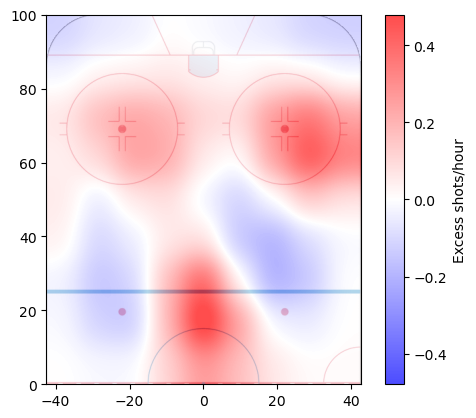

In [86]:
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

ring = "../../figures/nhl_rink.png"

rink_full = Image.open(ring).convert("RGBA")
W, H = rink_full.size
rink_half = rink_full.crop((W//2, 0, W, H))
rink_half_rot = rink_half.transpose(Image.ROTATE_90)

plt.imshow(rink_half_rot, extent=[X_MIN, X_MAX, Y_MIN, Y_MAX], alpha=1)

Z_raw = final_df.values.astype(float)
Z_smooth = gaussian_filter(Z_raw, sigma=0.8, mode="nearest")

raw_max = np.nanmax(np.abs(Z_raw))
smooth_max = max(np.nanmax(np.abs(Z_smooth)), 1e-12)
Z_smooth *= (raw_max / smooth_max)

lo, hi = np.percentile(Z_smooth, [2, 98])
max_abs = max(abs(lo), abs(hi))
vmin, vmax = -max_abs, +max_abs

X_MIN, X_MAX = -42.5, 42.5
Y_MIN, Y_MAX = 0, 100

plt.imshow(
    Z_smooth, cmap="bwr", interpolation="gaussian", alpha=0.7,
    extent=[X_MIN, X_MAX, Y_MIN, Y_MAX], vmin=vmin, vmax=vmax
)

plt.colorbar(label="Excess shots/hour")
plt.gca().set_aspect("equal", adjustable="box")
plt.xlim(X_MIN, X_MAX); plt.ylim(Y_MIN, Y_MAX)
plt.show()

<Axes: xlabel='coordinates_y_bins', ylabel='coordinates_x_bins'>

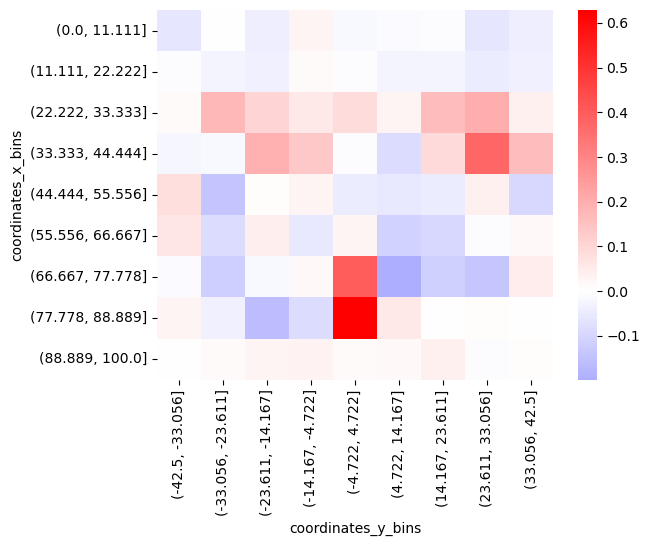

In [87]:
sns.heatmap(df_finale,  cmap ="bwr" , cbar=True , center=0)


In [88]:
#Ok so now we need to calculate the distances that we need to map the (x,y) points here, centre circle is going to be (0,0) and the goal post is going to be (89,3) in the (x,y) space 
#This was a stupid idea :D 
'''
def calculate_distance_crink(r):
    inter =  np.power( (abs ( r['coordinates_x']) - 0), 2) + np.power( (abs (r['coordinates_y']) - 9), 2)
    dist   = np.sqrt(inter)
    return dist 

def calculate_distance_goalie(row):
    dist   = np.sqrt( np.power ( (abs (row['coordinates_x']) - 89), 2) + np.power( (abs(row['coordinates_y']) - 3), 2) ) 
    return dist 
'''

"\ndef calculate_distance_crink(r):\n    inter =  np.power( (abs ( r['coordinates_x']) - 0), 2) + np.power( (abs (r['coordinates_y']) - 9), 2)\n    dist   = np.sqrt(inter)\n    return dist \n\ndef calculate_distance_goalie(row):\n    dist   = np.sqrt( np.power ( (abs (row['coordinates_x']) - 89), 2) + np.power( (abs(row['coordinates_y']) - 3), 2) ) \n    return dist \n"

In [89]:
df_sub[df_sub.isna().any(axis=1)]
df_league_stats[df_league_stats.isna().any(axis=1)]

,game_id,season,team_name,coordinates_x,coordinates_y,coordinates_x_bins,coordinates_y_bins
83326,2017020044,20172018,Canucks,0.0,10.0,NaN,"(4.722, 14.167]"
83988,2017020053,20172018,Stars,0.0,-29.0,NaN,"(-33.056, -23.611]"
84845,2017020068,20172018,Jets,0.0,1.0,NaN,"(-4.722, 4.722]"
84936,2017020069,20172018,Stars,0.0,-9.0,NaN,"(-14.167, -4.722]"
91808,2017020176,20172018,Stars,0.0,-22.0,NaN,"(-23.611, -14.167]"
95883,2017020239,20172018,Flames,0.0,3.0,NaN,"(-4.722, 4.722]"
102475,2017020344,20172018,Predators,0.0,23.0,NaN,"(14.167, 23.611]"
102939,2017020351,20172018,Red Wings,0.0,1.0,NaN,"(-4.722, 4.722]"
105378,2017020389,20172018,Islanders,0.0,1.0,NaN,"(-4.722, 4.722]"
109015,2017020445,20172018,Canadiens,0.0,-34.0,NaN,"(-42.5, -33.056]"


In [90]:
df_sub['coordinates_x'] = df_sub['coordinates_x'].apply(abs)
df_sub.head(100)

,game_id,season,team_name,coordinates_x,coordinates_y
80399,2017020001,20172018,Jets,36.0,-28.0
80400,2017020001,20172018,Jets,75.0,1.0
80401,2017020001,20172018,Jets,73.0,10.0
80402,2017020001,20172018,Maple Leafs,80.0,-3.0
80403,2017020001,20172018,Jets,44.0,-21.0
...,...,...,...,...,...
80494,2017020002,20172018,Blues,71.0,2.0
80495,2017020002,20172018,Blues,44.0,21.0
80496,2017020002,20172018,Penguins,77.0,-15.0
80497,2017020002,20172018,Blues,69.0,-36.0


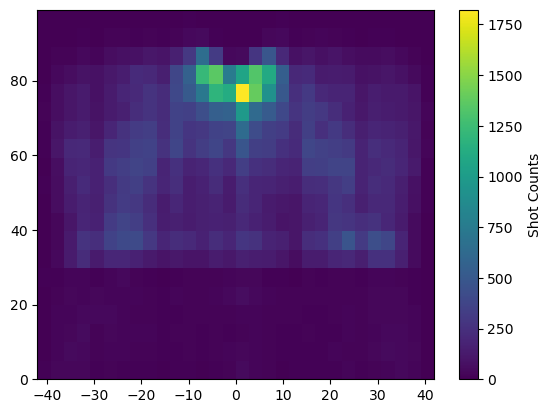

In [91]:
league_distances = df_sub[['coordinates_x', 'coordinates_y']].to_numpy()
H_mat1, xedg, yedg, img1  = plt.hist2d(league_distances[:,1], league_distances[:,0], bins=[30,20])
plt.colorbar(label = "Shot Counts")

C:\Users\Goofy\AppData\Local\Temp\ipykernel_10628\2779435997.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(90 - ticks)


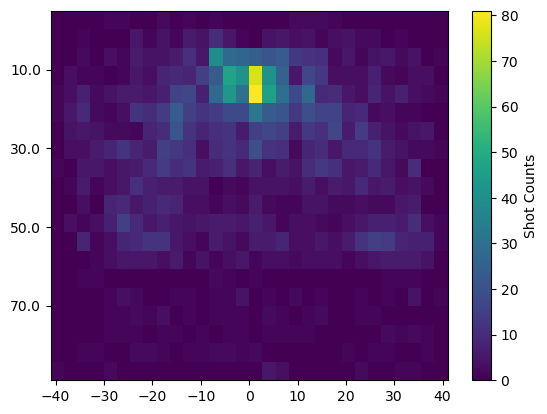

In [92]:
Toronto = df_sub[df_sub['team_name'] == "Maple Leafs"]
Toronto = Toronto[["coordinates_x", "coordinates_y"]].to_numpy()
H_mat2, x_edges2, y_edges2, _ = plt.hist2d(Toronto[:,1], Toronto[:,0] , bins=[30,20])
ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels(90 - ticks)
plt.colorbar(label = "Shot Counts")